In [1]:
import os, sys

# Add project root to sys.path so "import src..." works in notebooks
PROJECT_ROOT = os.path.abspath("..")  # because notebook is inside /notebooks
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("✅ Project root added:", PROJECT_ROOT)


✅ Project root added: c:\Users\windows\Documents\Personal projects\epl-match-prediction


In [2]:
# Imports + Load features (FAST)
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

path = "../data/model_features.csv"
print("Loading:", os.path.abspath(path))

model_df = pd.read_csv(path)
model_df["MatchDate"] = pd.to_datetime(model_df["MatchDate"], errors="coerce")

# safety
model_df = model_df.dropna(subset=["MatchDate", "target"]).sort_values("MatchDate").reset_index(drop=True)

print("✅ Loaded model_df shape:", model_df.shape)
print(model_df.head())


Loading: c:\Users\windows\Documents\Personal projects\epl-match-prediction\data\model_features.csv
✅ Loaded model_df shape: (9271, 8)
   MatchDate  home_gf_form  home_ga_form  home_matches  away_gf_form  \
0 2000-08-22           2.0           1.4             1           2.0   
1 2000-08-23           0.8           2.8             1           1.4   
2 2000-08-23           2.0           2.0             1           0.6   
3 2000-08-23           1.6           2.0             1           2.0   
4 2000-08-23           2.4           1.4             1           0.4   

   away_ga_form  away_matches  target  
0           0.8             1       1  
1           1.0             1       2  
2           2.2             1       0  
3           0.8             1       2  
4           2.0             1       0  


In [3]:
# Chronological train/test split (80/20)

split_idx = int(len(model_df) * 0.8)

train_df = model_df.iloc[:split_idx].copy()
test_df  = model_df.iloc[split_idx:].copy()

X_train = train_df.drop(columns=["MatchDate", "target"])
y_train = train_df["target"].astype(int)

X_test = test_df.drop(columns=["MatchDate", "target"])
y_test = test_df["target"].astype(int)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train dates:", train_df["MatchDate"].min(), "→", train_df["MatchDate"].max())
print("Test  dates:", test_df["MatchDate"].min(), "→", test_df["MatchDate"].max())


Train: (7416, 6) Test: (1855, 6)
Train dates: 2000-08-22 00:00:00 → 2020-09-12 00:00:00
Test  dates: 2020-09-12 00:00:00 → 2025-05-05 00:00:00


In [4]:
# Scale features (for Logistic Regression)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [5]:
# Logistic Regression baseline (compatible with older sklearn)

logreg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42,
    solver="lbfgs"
)

logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)

print("✅ Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=["Away", "Draw", "Home"]))



✅ Logistic Regression Accuracy: 0.48517520215633425
              precision    recall  f1-score   support

        Away       0.44      0.62      0.51       626
        Draw       0.27      0.05      0.08       427
        Home       0.55      0.61      0.58       802

    accuracy                           0.49      1855
   macro avg       0.42      0.43      0.39      1855
weighted avg       0.45      0.49      0.44      1855



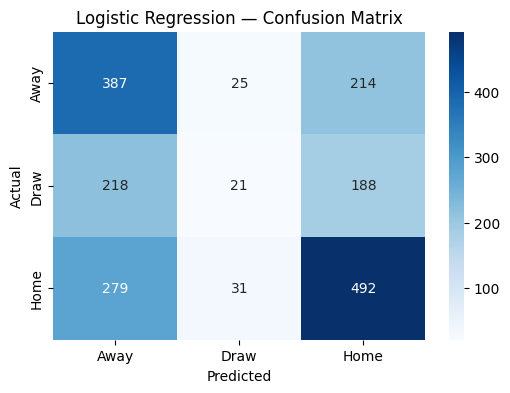

In [6]:
# Confusion matrix (LogReg)

cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_lr, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Away", "Draw", "Home"],
    yticklabels=["Away", "Draw", "Home"]
)
plt.title("Logistic Regression — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [7]:
# Random Forest (stronger model)

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("✅ Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=["Away", "Draw", "Home"]))


✅ Random Forest Accuracy: 0.49973045822102424
              precision    recall  f1-score   support

        Away       0.49      0.51      0.50       626
        Draw       0.32      0.08      0.13       427
        Home       0.53      0.71      0.61       802

    accuracy                           0.50      1855
   macro avg       0.44      0.44      0.41      1855
weighted avg       0.46      0.50      0.46      1855



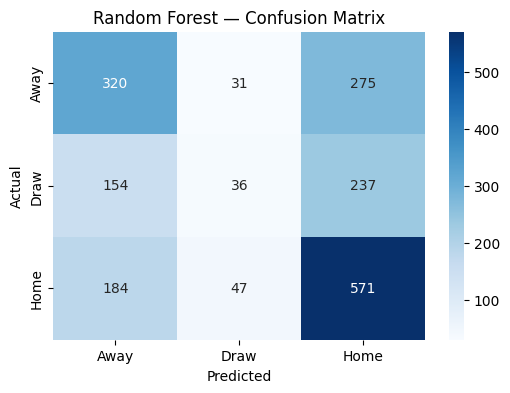

In [8]:
# Confusion matrix (RF)

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_rf, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Away", "Draw", "Home"],
    yticklabels=["Away", "Draw", "Home"]
)
plt.title("Random Forest — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


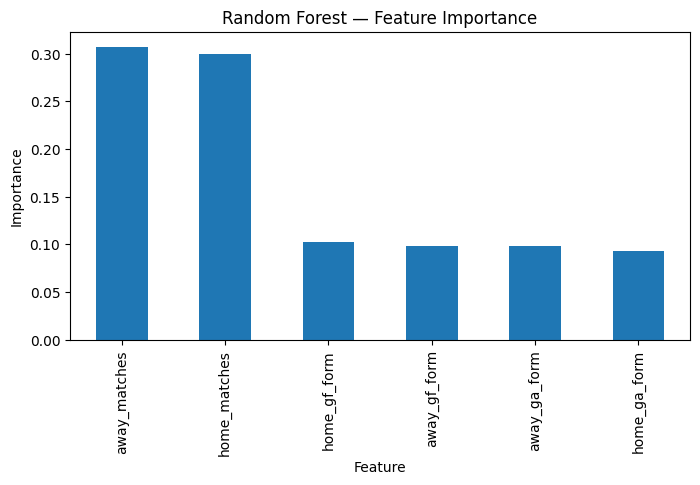

away_matches    0.307620
home_matches    0.299785
home_gf_form    0.102543
away_gf_form    0.098608
away_ga_form    0.098061
home_ga_form    0.093384
dtype: float64


In [9]:
# Feature importance (RF)

importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
importances.plot(kind="bar")
plt.title("Random Forest — Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

print(importances)


In [10]:
import os
from src.model import save_artifacts

os.makedirs("../artifacts", exist_ok=True)

save_artifacts(
    model=logreg,
    scaler=scaler,
    feature_cols=X_train.columns.tolist(),
    out_dir="../artifacts"
)


✅ Saved artifacts to ../artifacts/
